In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import scipy as sc
import seaborn as sns
import itertools
import math

!pip install pyproj
!pip install adjustText


from matplotlib.patches import Patch
from matplotlib.lines import Line2D
from matplotlib.ticker import MaxNLocator

from scipy.stats import gaussian_kde
from scipy import stats
from scipy.stats import linregress
from scipy.stats import shapiro, ks_2samp, levene, ttest_ind, mannwhitneyu
from collections import OrderedDict


from pyproj import Transformer

from adjustText import adjust_text

In [17]:
df2 = pd.read_csv("Profiles.csv")
df3 = pd.read_csv("XSection.csv")

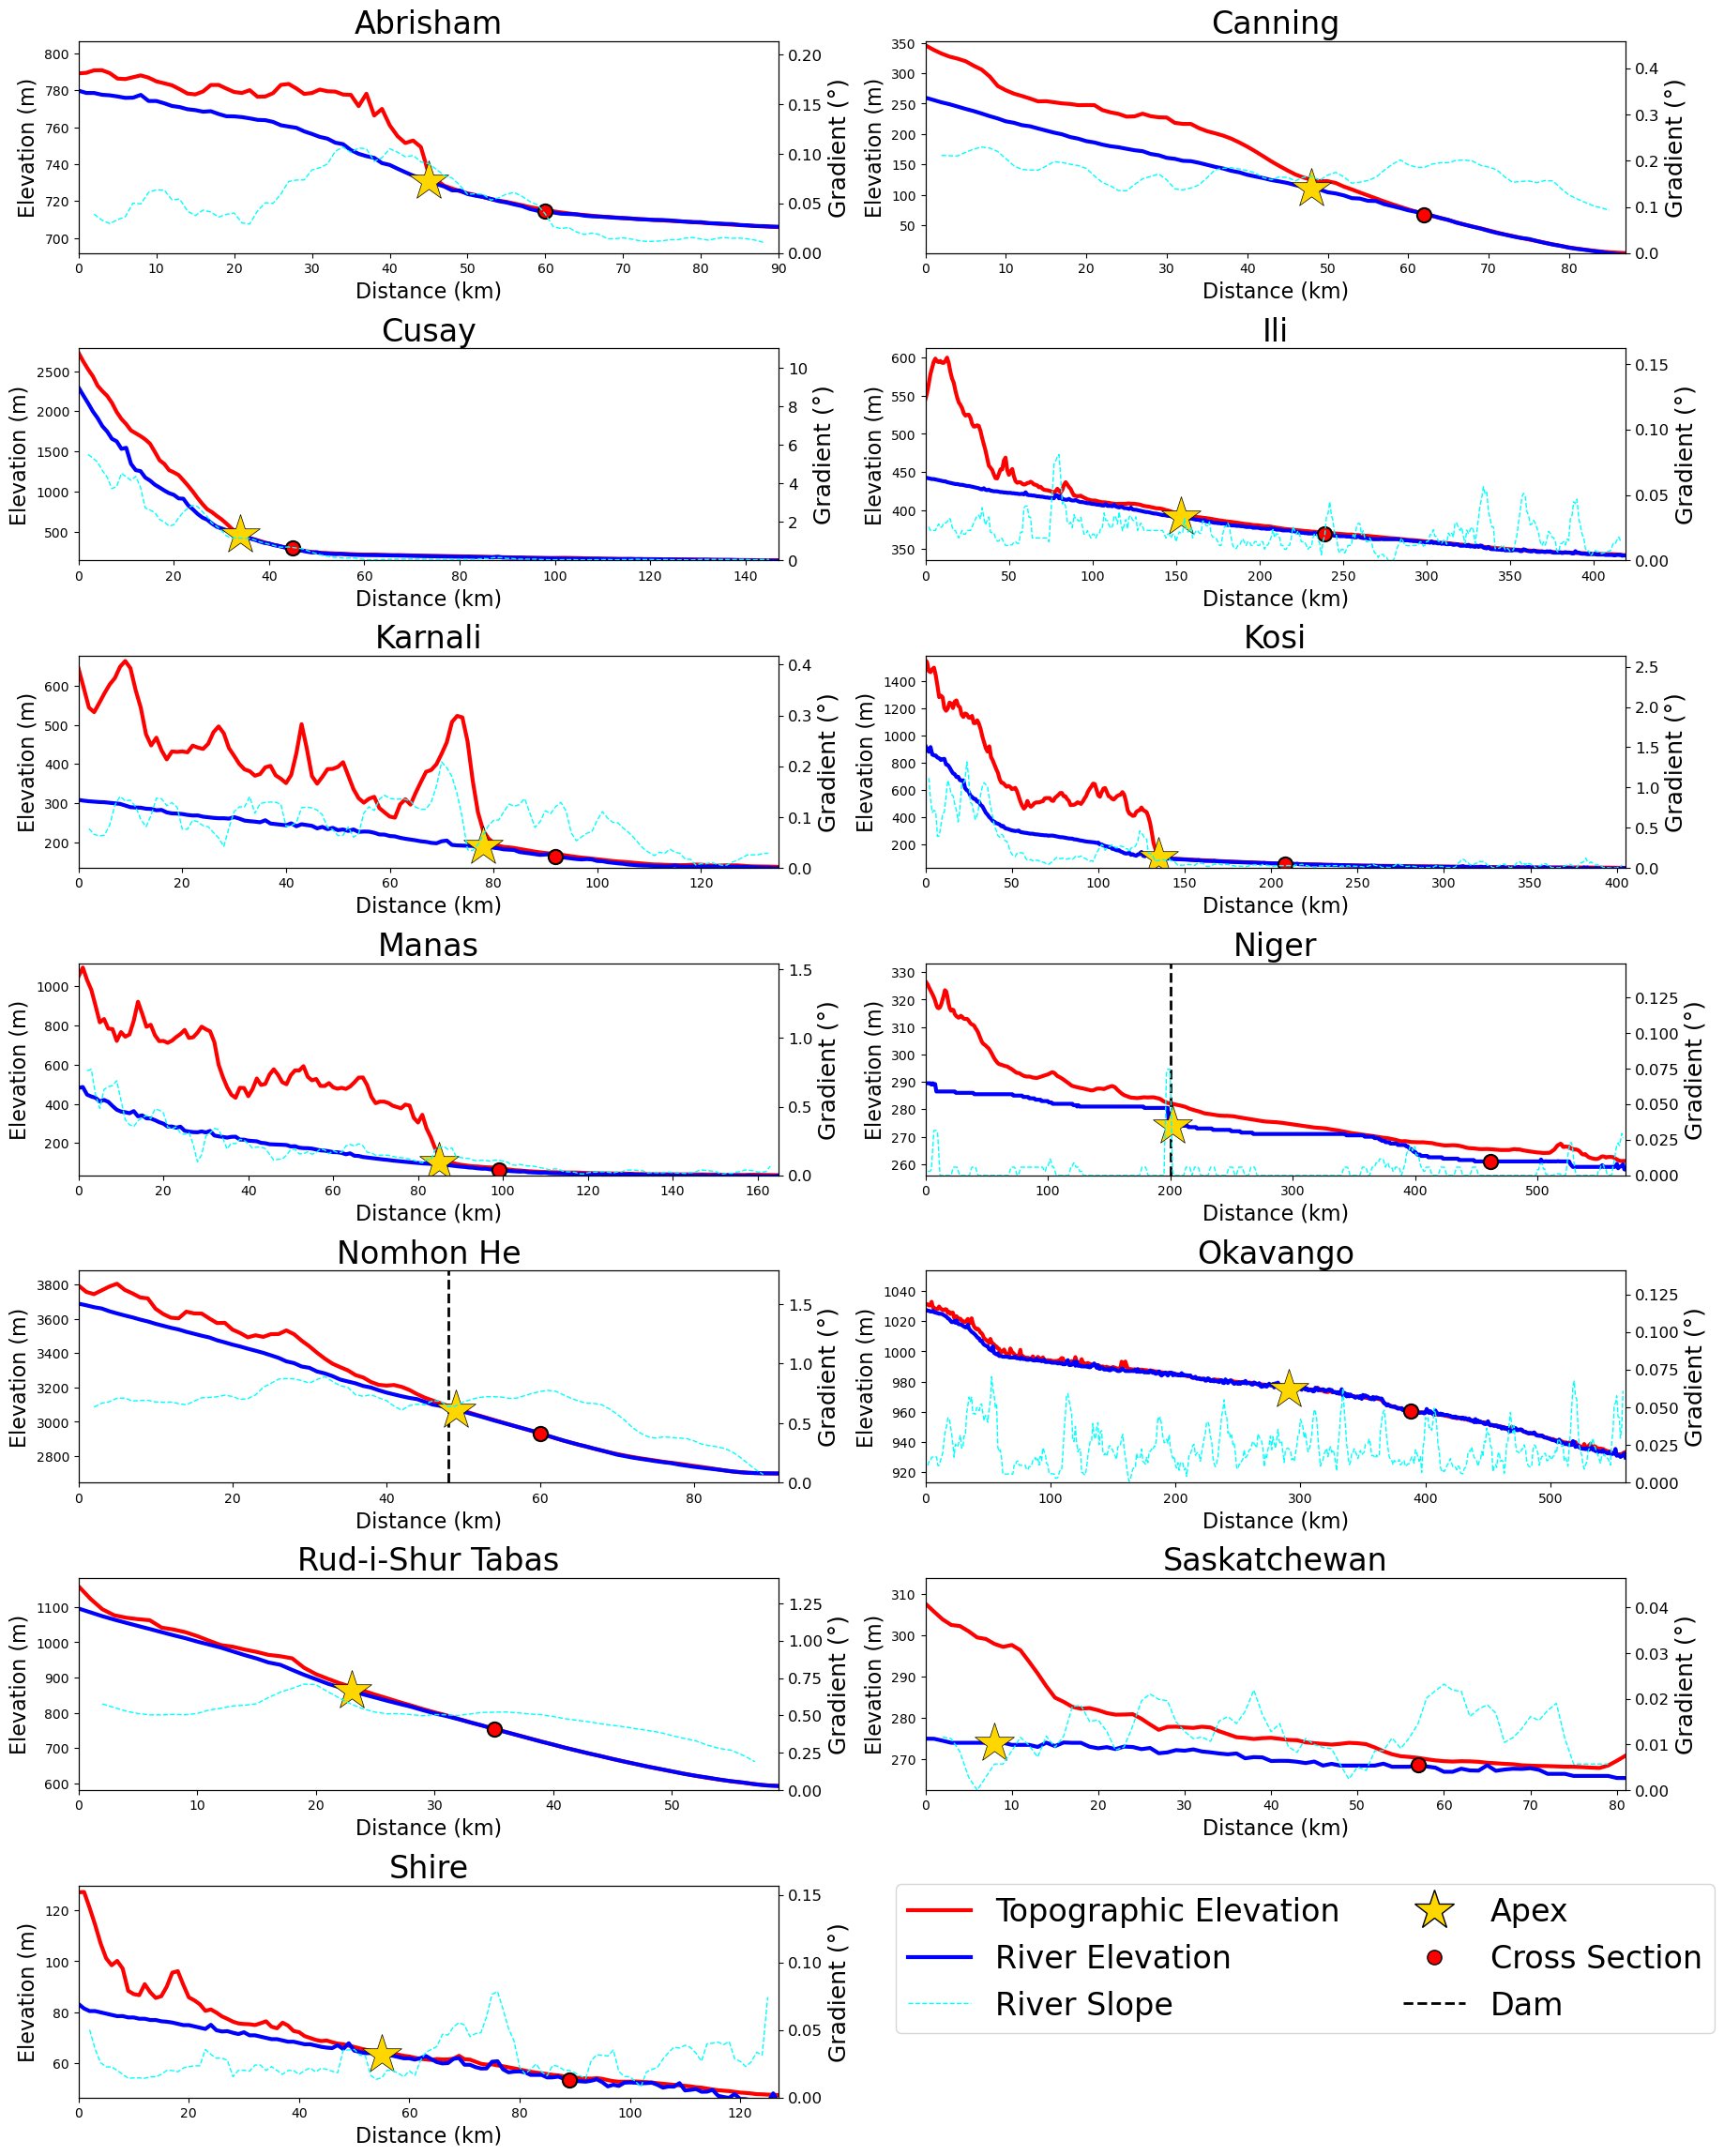

In [18]:
# -------------------------------
# Strip column names
df2.columns = df2.columns.str.strip()

# List of unique fans
fan_list = df2['Fan'].unique()

# Optional: manual Dam markers per fan
dam_dict = {
    'Nomhon He': [48],
    'Niger': [200]
}

# Smoothing window sizes
window_topo = 1
window_river = 1
window_slope = 5

# -------------------------------
# Subplot layout: 2 columns, dynamic rows
ncols = 2
nrows = int(np.ceil(len(fan_list) / ncols))
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(20, 3.4 * nrows))
axes = axes.flatten()

# Prepare legend handles for global legend (match actual plot sizes)
apex_marker_size = 1000  # same as s in scatter
cross_marker_size = 120  # same as s in scatter

apex_legend = plt.Line2D([0], [0], marker='*', color='gold', markerfacecolor='gold',
                         markersize=np.sqrt(apex_marker_size), markeredgecolor='black', linewidth=0)
cross_legend = plt.Line2D([0], [0], marker='o', color='red', markerfacecolor='red',
                          markersize=np.sqrt(cross_marker_size), markeredgecolor='black', linewidth=0)
dam_legend = plt.Line2D([0], [0], color='black', linestyle='--', linewidth=2, label='Dam')

# -------------------------------
# Loop through each fan
for i, fan_name in enumerate(fan_list):
    ax1 = axes[i]

    # Filter and sort
    df_fan = df2[df2['Fan'] == fan_name].copy().sort_values("Distance")

    # Interpolate missing values
    df_fan['Mean Elevation'] = df_fan['Mean Elevation'].interpolate(method='linear')
    df_fan['Topo_elev_smooth'] = df_fan['Mean Elevation'].rolling(window=window_topo, center=True).mean()
    df_fan['River_elev_smooth'] = df_fan['River Elevation'].rolling(window=window_river, center=True).mean()

    # River slope
    gradient_river = np.gradient(df_fan['River Elevation'], df_fan['Distance'] * 1000)
    df_fan['River_slope_deg'] = np.degrees(np.arctan(np.abs(gradient_river)))
    df_fan['River_slope_deg_smooth'] = df_fan['River_slope_deg'].rolling(window=window_slope, center=True).mean()

    # Plot elevations
    topo_line, = ax1.plot(df_fan['Distance'], df_fan['Topo_elev_smooth'],
                          color='red', linewidth=3, zorder=1)
    river_line, = ax1.plot(df_fan['Distance'], df_fan['River_elev_smooth'],
                           color='blue', linewidth=3, zorder=2)

    # Vertical dashed lines for Dams
    for dam in dam_dict.get(fan_name, []):
        ax1.axvline(x=dam, color='black', linestyle='--', linewidth=2, zorder=3)

    # Apex marker (yellow star)
    if 'Apex' in df_fan.columns:
        apex_data = df_fan[df_fan['Apex'] == 'Apex']
        if not apex_data.empty:
            ax1.scatter(apex_data['Distance'], df_fan.loc[apex_data.index, 'River_elev_smooth'],
                        marker='*', s=apex_marker_size, color='gold', edgecolor='black', linewidths=0.5, zorder=5)

    # Cross Section marker (red circle)
    cross_data = df_fan[df_fan['Cross Section'] == 'Cross Section']
    if not cross_data.empty:
        ax1.scatter(cross_data['Distance'], df_fan.loc[cross_data.index, 'River_elev_smooth'],
                    marker='o', s=cross_marker_size, color='red', edgecolor='black', linewidths=1.5, zorder=6)

    # Dynamic y-limits for elevation
    ymin, ymax = df_fan['Topo_elev_smooth'].min(), df_fan['Topo_elev_smooth'].max()
    ax1.set_ylim(0.98 * ymin, 1.02 * ymax)

    # Force x-axis to go exactly from first to last data point
    ax1.set_xlim(df_fan['Distance'].min(), df_fan['Distance'].max())
    ax1.margins(x=0)  # remove extra horizontal padding

    ax1.set_xlabel('Distance (km)', fontsize=16)
    ax1.set_ylabel('Elevation (m)', fontsize=16)
    ax1.tick_params(axis='both', labelsize=10)
    ax1.set_title(fan_name, fontsize=24)

    # Secondary axis: slope
    ax2 = ax1.twinx()
    slope_line, = ax2.plot(df_fan['Distance'], df_fan['River_slope_deg_smooth'],
                           color='cyan', linestyle='--', linewidth=1, zorder=1)
    ax2.set_ylabel('Gradient (°)', fontsize=18)
    ax2.tick_params(axis='y', labelsize=12)
    max_slope = df_fan['River_slope_deg_smooth'].max()
    ax2.set_ylim(0, 2 * max_slope if max_slope > 0 else 0.5)

# Hide unused subplots
for j in range(len(fan_list), len(axes)):
    axes[j].axis('off')

# -------------------------------
# Single global legend at lower-right
fig.legend([topo_line, river_line, slope_line, apex_legend, cross_legend, dam_legend],
           ['Topographic Elevation', 'River Elevation', 'River Slope', 'Apex', 'Cross Section', 'Dam'],
           loc='lower right', fontsize=24, ncol=2, bbox_to_anchor=(0.925, 0.05))

plt.tight_layout(rect=[0, 0, 0.92, 0.97])
plt.show()


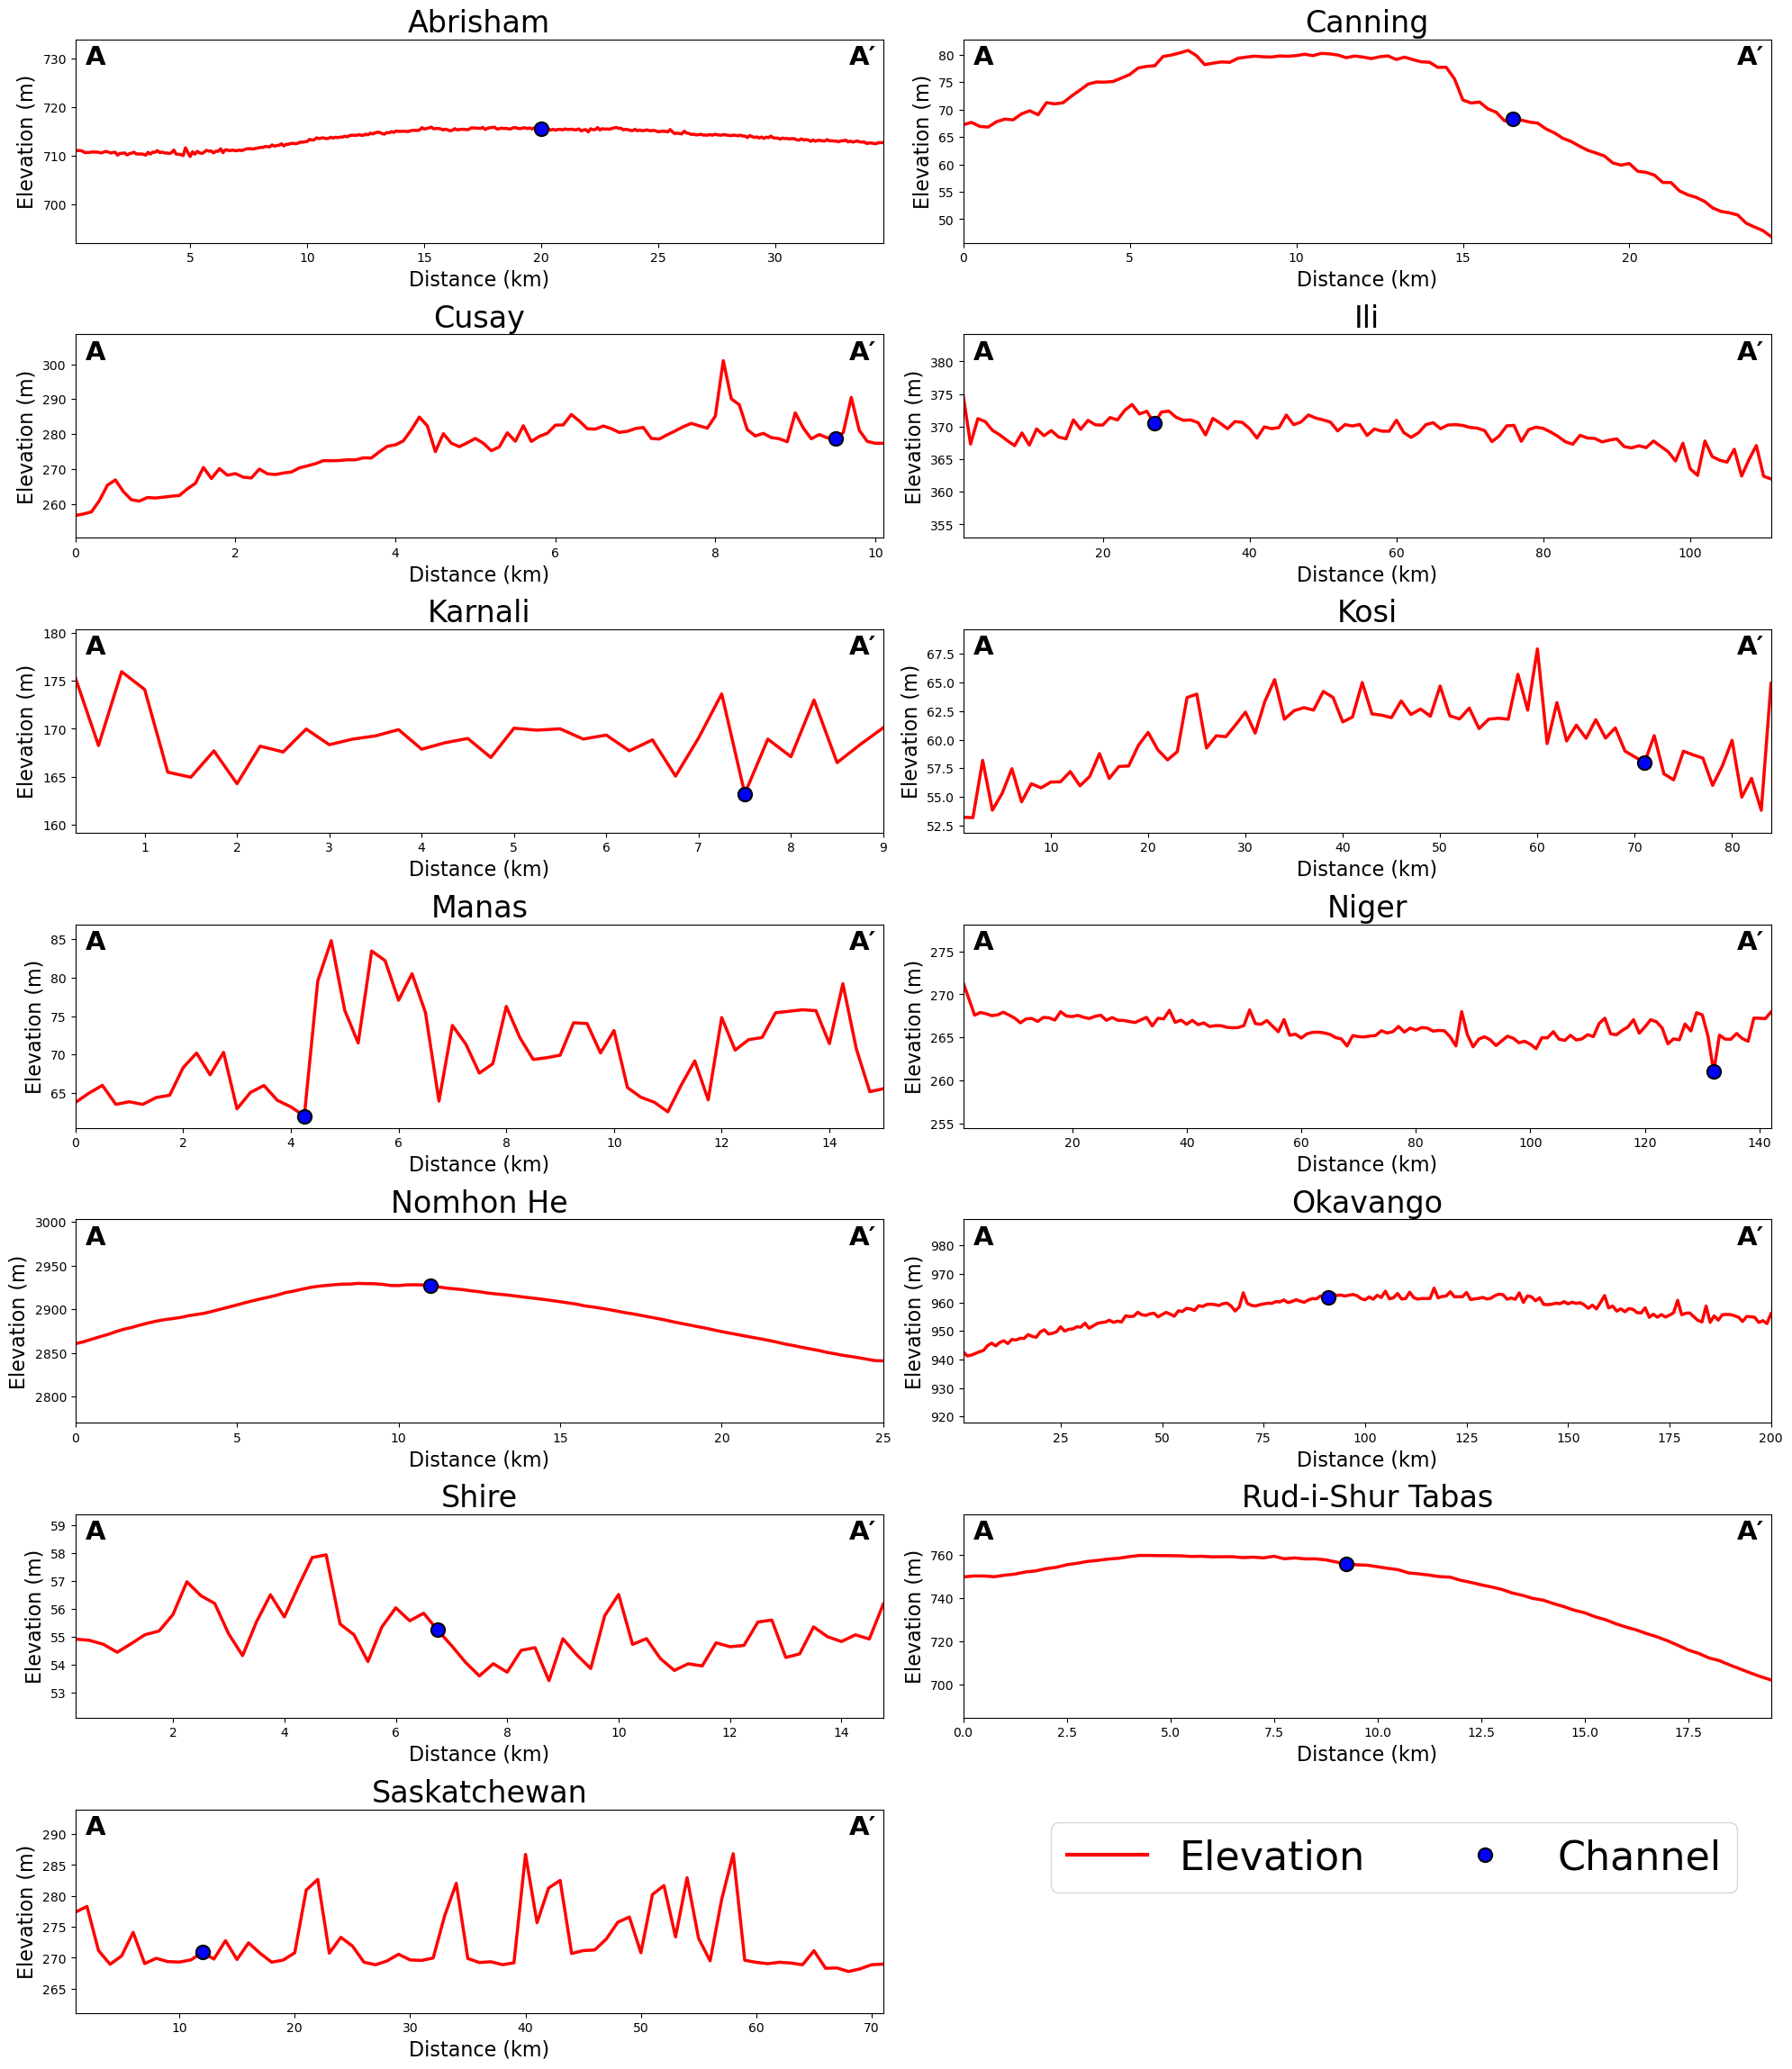

In [19]:
# -------------------------------
# Get unique fans from df3
fan_list = df3['Fan'].unique()
channel_circle_size = 120  # same as cross-section
channel_edgewidth = 1.5

# -------------------------------
# Cross-section label offsets
x_offset = 0.025  # relative x-position for A/A′
y_fixed = 0.975  # relative y-position for A/A′
label_size = 21  # font size for A/A′

# -------------------------------
# Create 2-column subplot grid (rows adjust automatically)
ncols = 2
nrows = int(np.ceil(len(fan_list) / ncols))
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(20, 3.4 * nrows))
axes = axes.flatten()

# -------------------------------
# Loop through each fan and plot
for i, fan_name in enumerate(fan_list):
    ax = axes[i]
    
    # Filter and sort
    df_fan = df3[df3['Fan'] == fan_name].copy().sort_values("Distance")
    df_fan['Elevation'] = df_fan['Elevation'].interpolate(method='linear')
    
    # Red line: cross-section elevation
    ax.plot(df_fan['Distance'], df_fan['Elevation'], color='red', linewidth=2.5, zorder=1)

    # Blue circles: channel points (match cross-section style)
    df_channel = df_fan[df_fan['Channel'] == "Channel"]
    ax.scatter(df_channel['Distance'], df_channel['Elevation'],
               color='blue', s=channel_circle_size,
               edgecolor='black', linewidths=channel_edgewidth,
               marker='o', zorder=2)
    
    # Axis formatting
    ymin, ymax = df_fan['Elevation'].min(), df_fan['Elevation'].max()
    ax.set_ylim(0.975 * ymin, 1.025 * ymax)
    ax.margins(x=0)  #  horizontal whitespace

    ax.set_title(fan_name, fontsize=24)
    ax.set_xlabel('Distance (km)', fontsize=16)
    ax.set_ylabel('Elevation (m)', fontsize=16)
    ax.tick_params(axis='both', labelsize=10)
    ax.grid(False)
    
    # Add A and A′ labels inside plot frame
    ax.text(x_offset, y_fixed, "A", fontsize=label_size, fontweight='bold',
            ha='center', va='top', transform=ax.transAxes)
    ax.text(1 - x_offset, y_fixed, "A′", fontsize=label_size, fontweight='bold',
            ha='center', va='top', transform=ax.transAxes)

# Hide unused subplots
for j in range(len(fan_list), len(axes)):
    axes[j].axis('off')

# -------------------------------
# Global legend using proxy artists (match marker style)
legend_handles = [
    Line2D([0], [0], color='red', linewidth=3, label='Elevation'),
    Line2D([0], [0], marker='o', color='blue', markerfacecolor='blue',
           markeredgecolor='black', markersize=np.sqrt(channel_circle_size),
           linestyle='None', label='Channel', markeredgewidth=channel_edgewidth)
]

fig.legend(handles=legend_handles,
           loc='lower left', fontsize=32, ncol=2, bbox_to_anchor=(0.575, .075))

plt.tight_layout(rect=[0, 0, 1, 0.97])
plt.show()


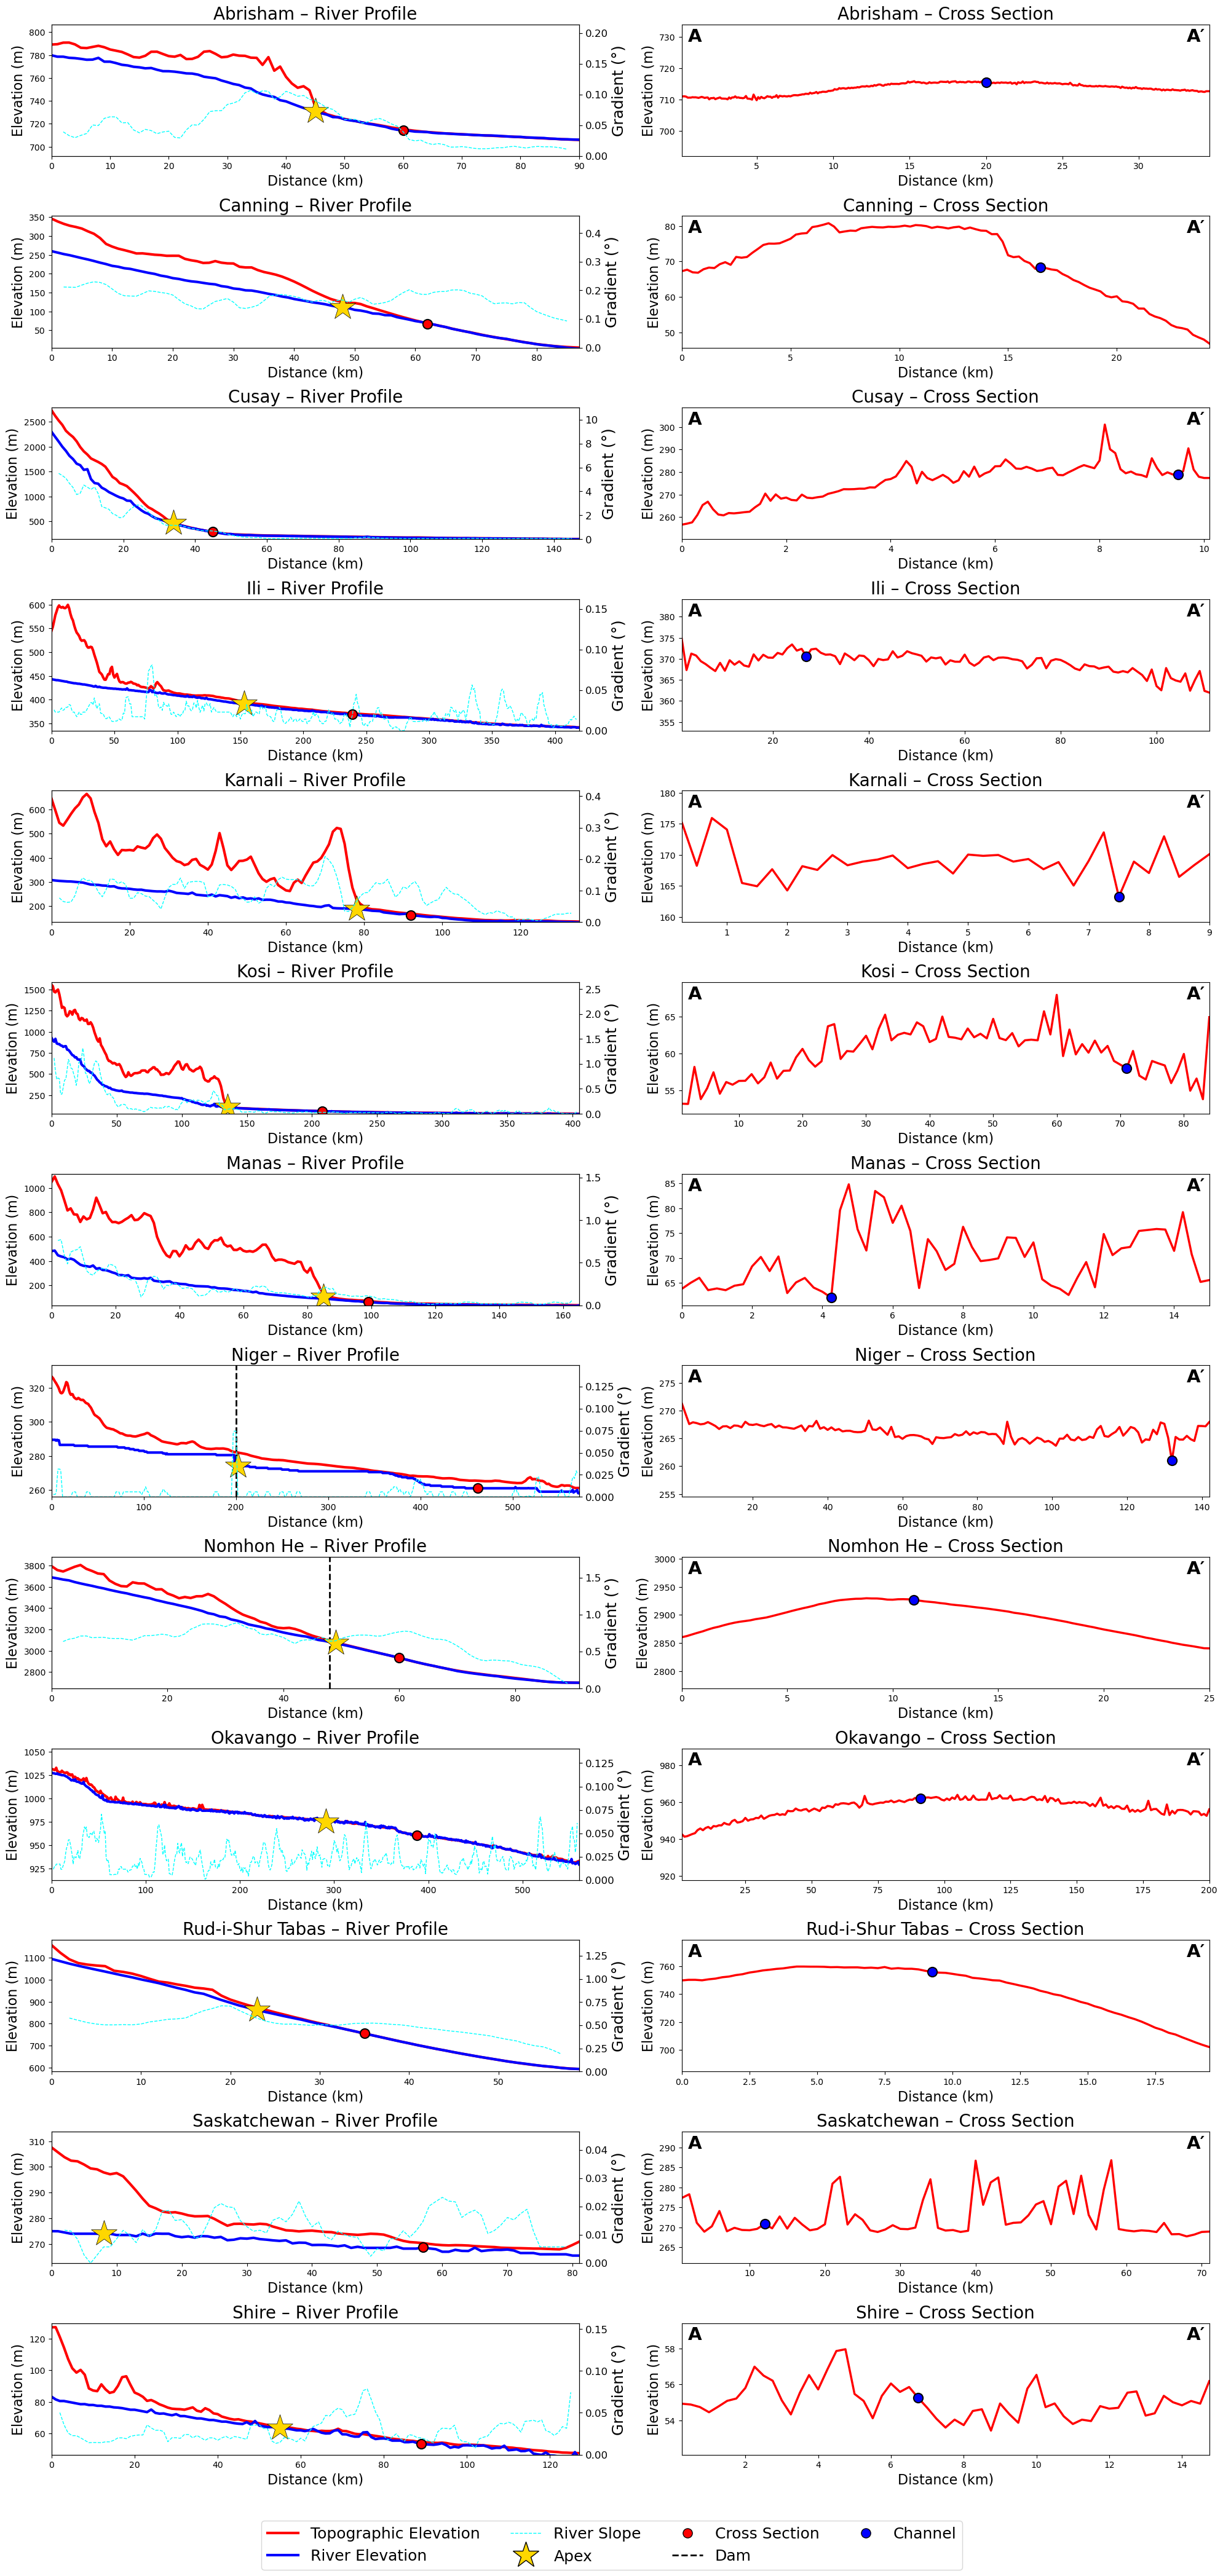

In [20]:
# =====================================================
# Combined plotting: River Profiles (left) + Cross Sections (right)
# =====================================================

# -------------------------------
# Clean column names
df2.columns = df2.columns.str.strip()
df3.columns = df3.columns.str.strip()

# List of unique fans
fan_list = sorted(set(df2['Fan']).intersection(df3['Fan']))

# Optional: dam markers per fan (km)
dam_dict = {
    'Nomhon He': [48],
    'Niger': [200]
}

# -------------------------------
# Styling and constants
window_topo = 1
window_river = 1
window_slope = 5
apex_marker_size = 1000
cross_marker_size = 120
channel_circle_size = 120
channel_edgewidth = 1.5
x_offset = 0.025
y_fixed = 0.975
label_size = 21

# -------------------------------
# Create figure: 2 columns (river | cross-section), dynamic rows
ncols = 2
nrows = int(np.ceil(len(fan_list)))
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(20, 3.4 * nrows))
axes = axes.reshape(nrows, ncols)

# -------------------------------
# Loop through each fan
for i, fan_name in enumerate(fan_list):
    # ------------------------------------------------
    # LEFT COLUMN – River & topographic profiles
    # ------------------------------------------------
    ax1 = axes[i, 0]
    df_fan2 = df2[df2['Fan'] == fan_name].copy().sort_values("Distance")

    # Interpolate and smooth
    df_fan2['Mean Elevation'] = df_fan2['Mean Elevation'].interpolate(method='linear')
    df_fan2['Topo_elev_smooth'] = df_fan2['Mean Elevation'].rolling(window=window_topo, center=True).mean()
    df_fan2['River_elev_smooth'] = df_fan2['River Elevation'].rolling(window=window_river, center=True).mean()

    # River slope
    gradient_river = np.gradient(df_fan2['River Elevation'], df_fan2['Distance'] * 1000)
    df_fan2['River_slope_deg'] = np.degrees(np.arctan(np.abs(gradient_river)))
    df_fan2['River_slope_deg_smooth'] = df_fan2['River_slope_deg'].rolling(window=window_slope, center=True).mean()

    # Plot elevations
    topo_line, = ax1.plot(df_fan2['Distance'], df_fan2['Topo_elev_smooth'],
                          color='red', linewidth=3, zorder=1)
    river_line, = ax1.plot(df_fan2['Distance'], df_fan2['River_elev_smooth'],
                           color='blue', linewidth=3, zorder=2)

    # Dams
    for dam in dam_dict.get(fan_name, []):
        ax1.axvline(x=dam, color='black', linestyle='--', linewidth=2, zorder=3)

    # Apex markers
    if 'Apex' in df_fan2.columns:
        apex_data = df_fan2[df_fan2['Apex'] == 'Apex']
        if not apex_data.empty:
            ax1.scatter(apex_data['Distance'], df_fan2.loc[apex_data.index, 'River_elev_smooth'],
                        marker='*', s=apex_marker_size, color='gold', edgecolor='black',
                        linewidths=0.5, zorder=5)

    # Cross-section markers
    if 'Cross Section' in df_fan2.columns:
        cross_data = df_fan2[df_fan2['Cross Section'] == 'Cross Section']
        if not cross_data.empty:
            ax1.scatter(cross_data['Distance'], df_fan2.loc[cross_data.index, 'River_elev_smooth'],
                        marker='o', s=cross_marker_size, color='red', edgecolor='black',
                        linewidths=1.5, zorder=6)

    # Axis formatting
    ymin, ymax = df_fan2['Topo_elev_smooth'].min(), df_fan2['Topo_elev_smooth'].max()
    ax1.set_ylim(0.98 * ymin, 1.02 * ymax)
    ax1.set_xlim(df_fan2['Distance'].min(), df_fan2['Distance'].max())
    ax1.margins(x=0)
    ax1.set_xlabel('Distance (km)', fontsize=16)
    ax1.set_ylabel('Elevation (m)', fontsize=16)
    ax1.tick_params(axis='both', labelsize=10)
    ax1.set_title(f"{fan_name} – River Profile", fontsize=20)

    # Secondary y-axis for slope
    ax2 = ax1.twinx()
    slope_line, = ax2.plot(df_fan2['Distance'], df_fan2['River_slope_deg_smooth'],
                           color='cyan', linestyle='--', linewidth=1, zorder=1)
    ax2.set_ylabel('Gradient (°)', fontsize=18)
    ax2.tick_params(axis='y', labelsize=12)
    max_slope = df_fan2['River_slope_deg_smooth'].max()
    ax2.set_ylim(0, 2 * max_slope if max_slope > 0 else 0.5)

    # ------------------------------------------------
    # RIGHT COLUMN – Cross-section profiles
    # ------------------------------------------------
    ax3 = axes[i, 1]
    df_fan3 = df3[df3['Fan'] == fan_name].copy().sort_values("Distance")
    df_fan3['Elevation'] = df_fan3['Elevation'].interpolate(method='linear')

    # Red line: cross-section elevation
    ax3.plot(df_fan3['Distance'], df_fan3['Elevation'],
             color='red', linewidth=2.5, zorder=1)

    # Blue circles: channel points
    df_channel = df_fan3[df_fan3['Channel'] == "Channel"]
    ax3.scatter(df_channel['Distance'], df_channel['Elevation'],
                color='blue', s=channel_circle_size,
                edgecolor='black', linewidths=channel_edgewidth,
                marker='o', zorder=2)

    # Axis formatting
    ymin3, ymax3 = df_fan3['Elevation'].min(), df_fan3['Elevation'].max()
    ax3.set_ylim(0.975 * ymin3, 1.025 * ymax3)
    ax3.margins(x=0)
    ax3.set_xlabel('Distance (km)', fontsize=16)
    ax3.set_ylabel('Elevation (m)', fontsize=16)
    ax3.tick_params(axis='both', labelsize=10)
    ax3.set_title(f"{fan_name} – Cross Section", fontsize=20)
    ax3.grid(False)

    # A/A′ labels
    ax3.text(x_offset, y_fixed, "A", fontsize=label_size, fontweight='bold',
             ha='center', va='top', transform=ax3.transAxes)
    ax3.text(1 - x_offset, y_fixed, "A′", fontsize=label_size, fontweight='bold',
             ha='center', va='top', transform=ax3.transAxes)

# Hide unused rows
for j in range(len(fan_list), nrows):
    for k in range(ncols):
        axes[j, k].axis('off')

# -------------------------------
# Global legend
topo_line_proxy = Line2D([0], [0], color='red', linewidth=3, label='Topographic Elevation')
river_line_proxy = Line2D([0], [0], color='blue', linewidth=3, label='River Elevation')
slope_line_proxy = Line2D([0], [0], color='cyan', linestyle='--', linewidth=1, label='River Slope')
apex_proxy = Line2D([0], [0], marker='*', color='gold', markerfacecolor='gold',
                    markersize=np.sqrt(apex_marker_size), markeredgecolor='black', linestyle='None', label='Apex')
cross_proxy = Line2D([0], [0], marker='o', color='red', markerfacecolor='red',
                     markeredgecolor='black', markersize=np.sqrt(cross_marker_size),
                     linestyle='None', label='Cross Section')
dam_proxy = Line2D([0], [0], color='black', linestyle='--', linewidth=2, label='Dam')
channel_proxy = Line2D([0], [0], marker='o', color='blue', markerfacecolor='blue',
                       markeredgecolor='black', markersize=np.sqrt(channel_circle_size),
                       linestyle='None', label='Channel')

fig.legend(
    handles=[topo_line_proxy, river_line_proxy, slope_line_proxy, apex_proxy,
             cross_proxy, dam_proxy, channel_proxy],
    loc='lower center', fontsize=18, ncol=4, bbox_to_anchor=(0.5, 0.02)
)

plt.tight_layout(rect=[0, 0.05, 1, 0.97])
plt.show()


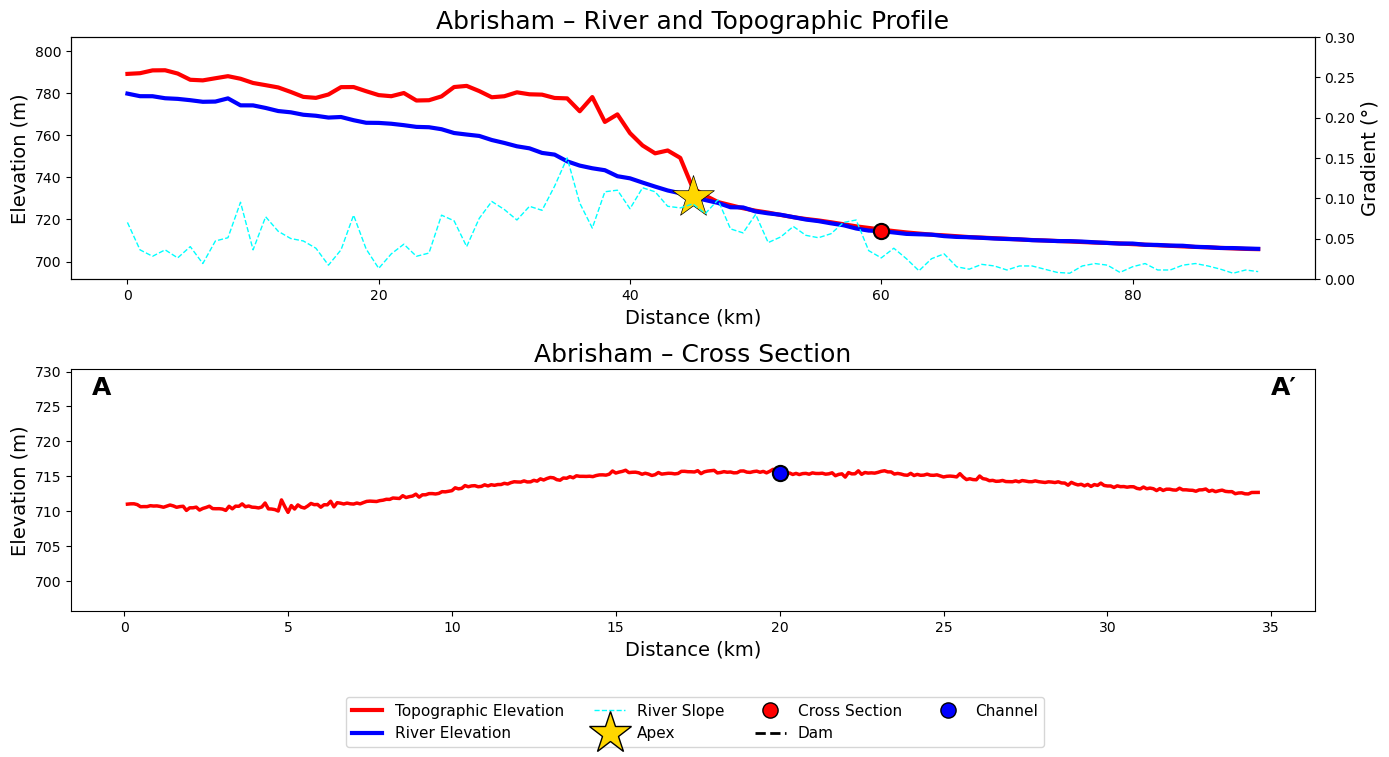

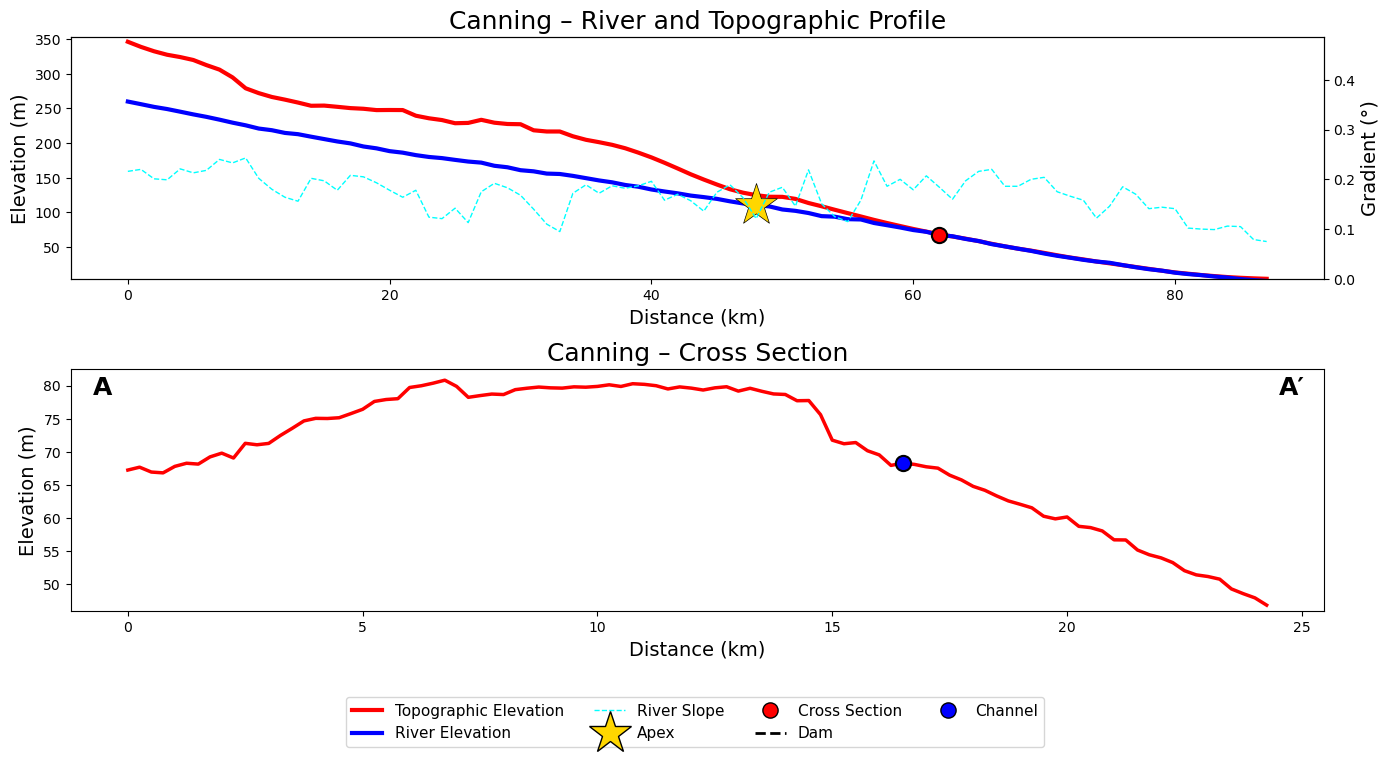

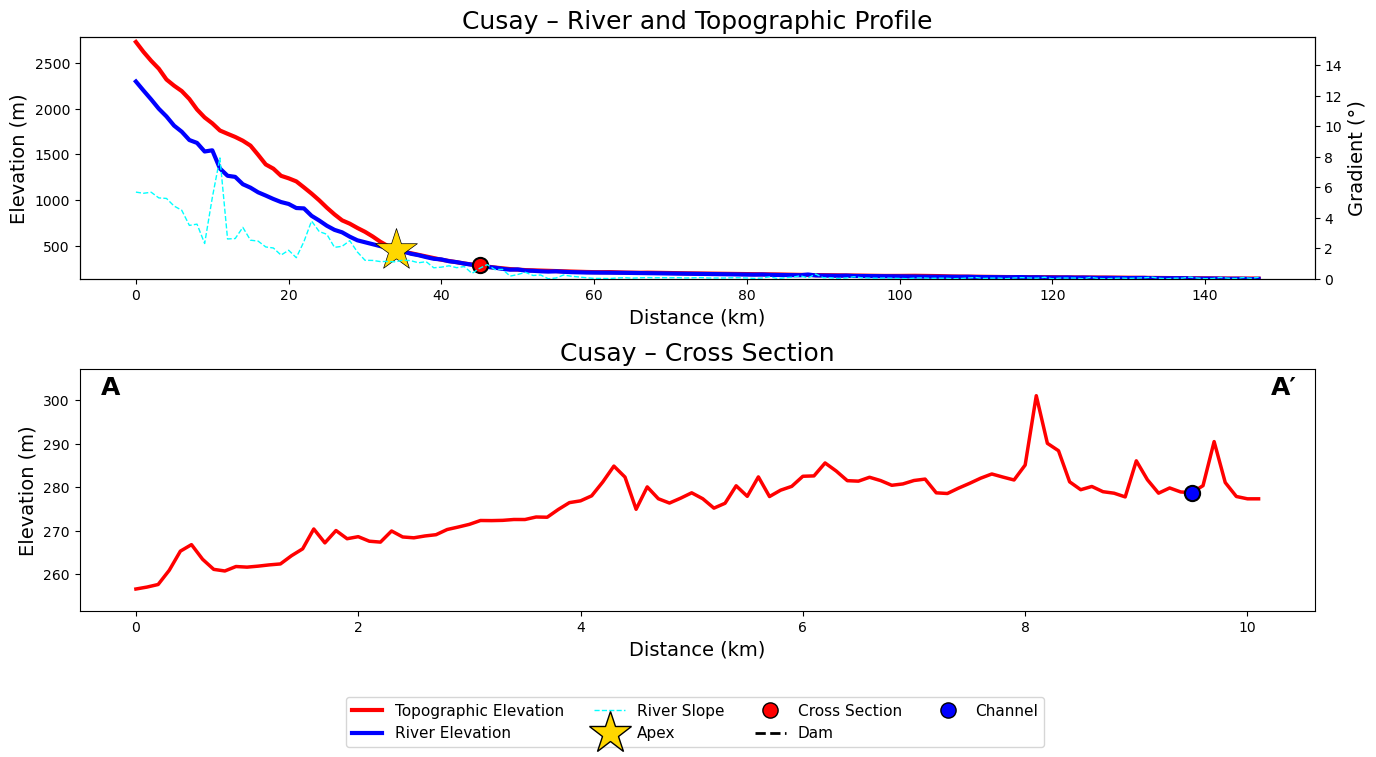

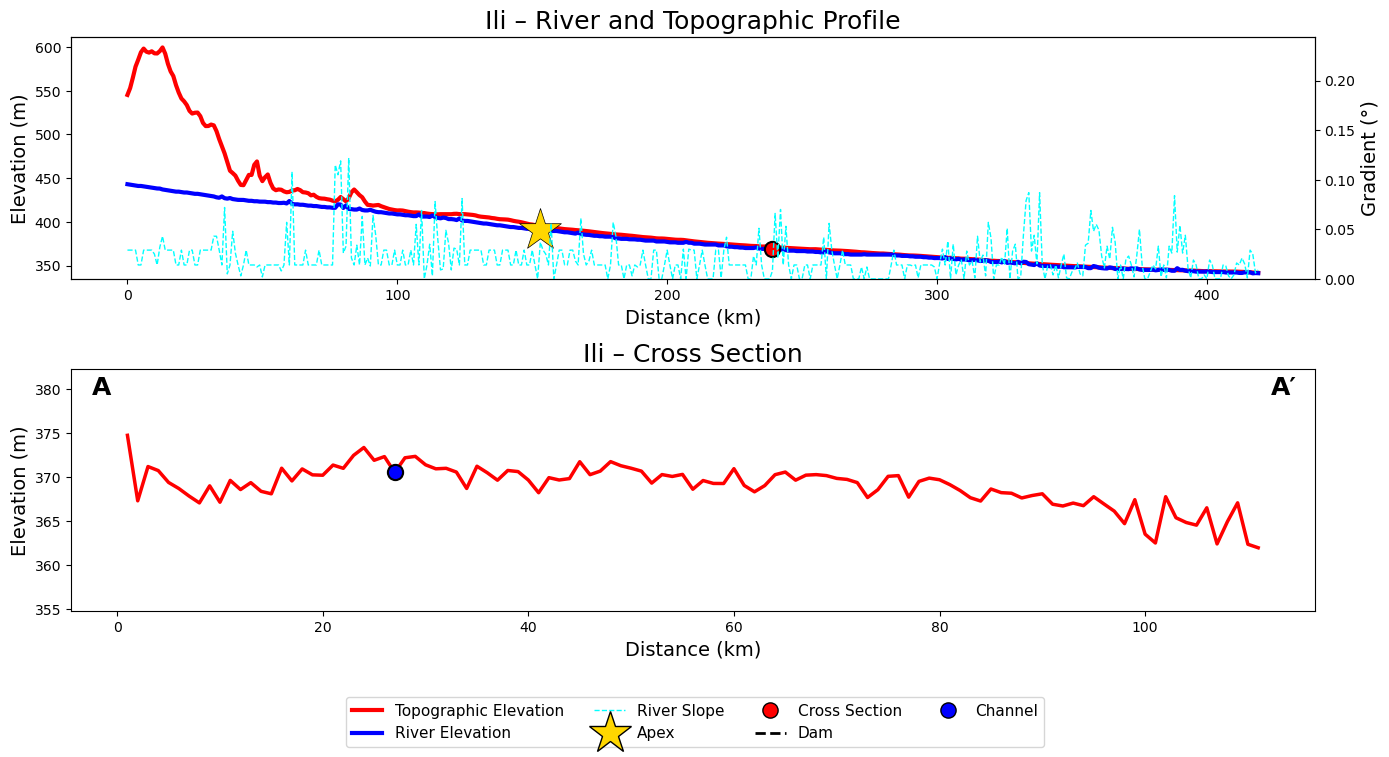

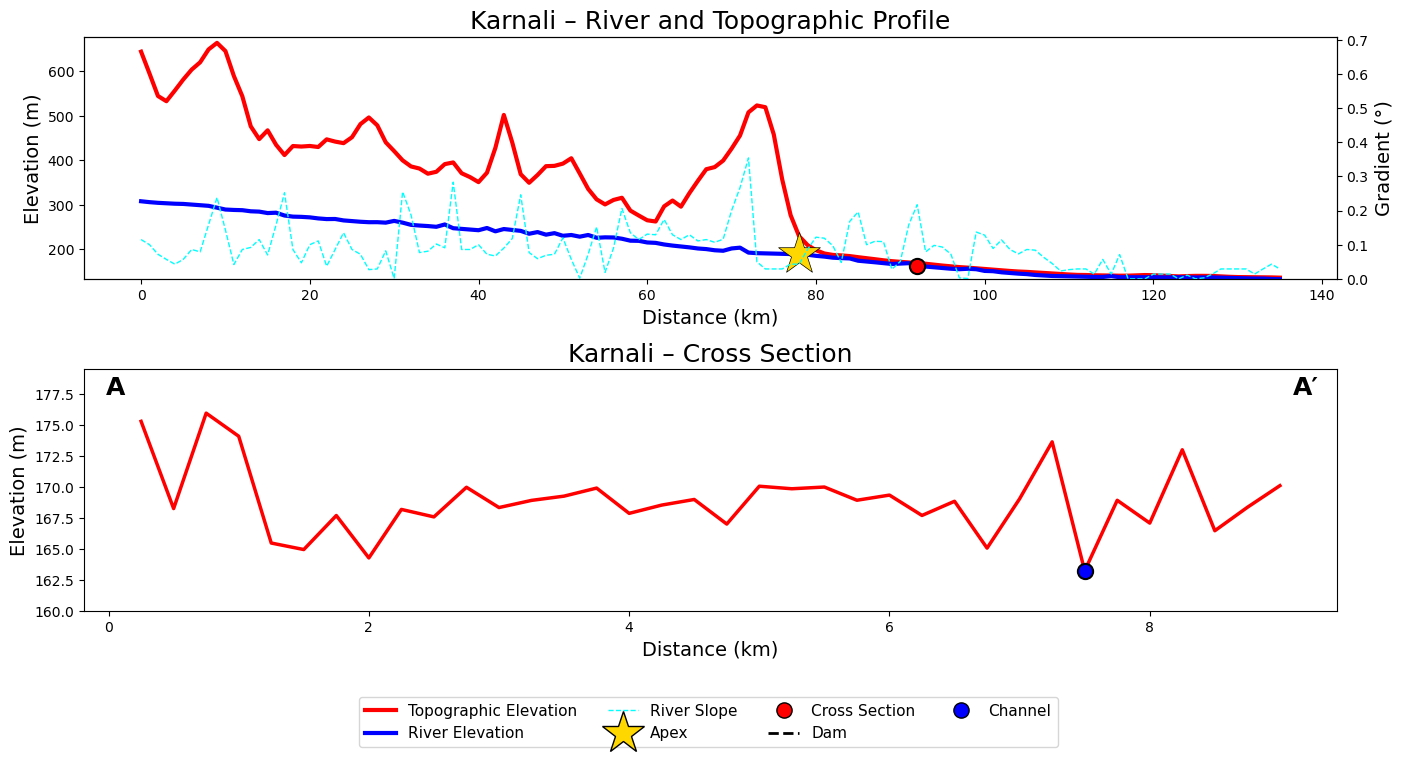

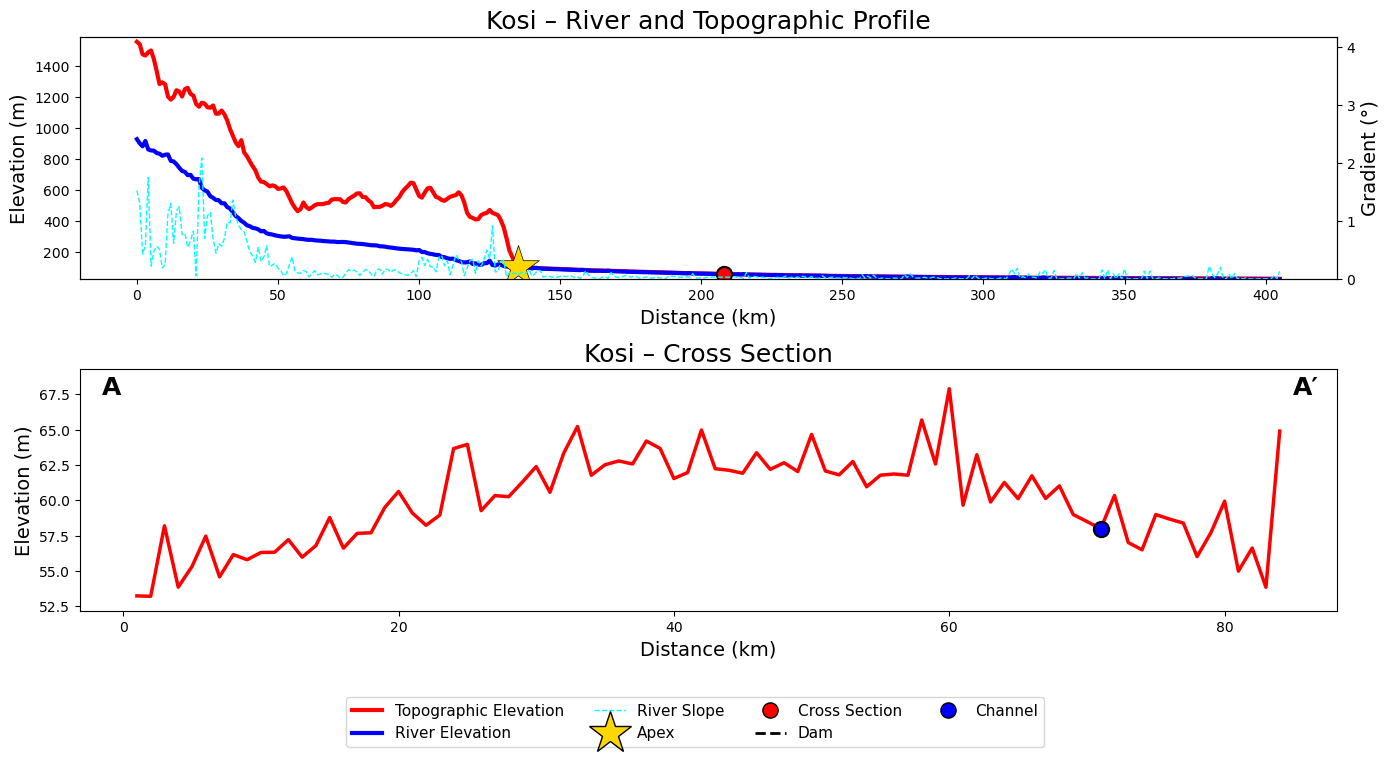

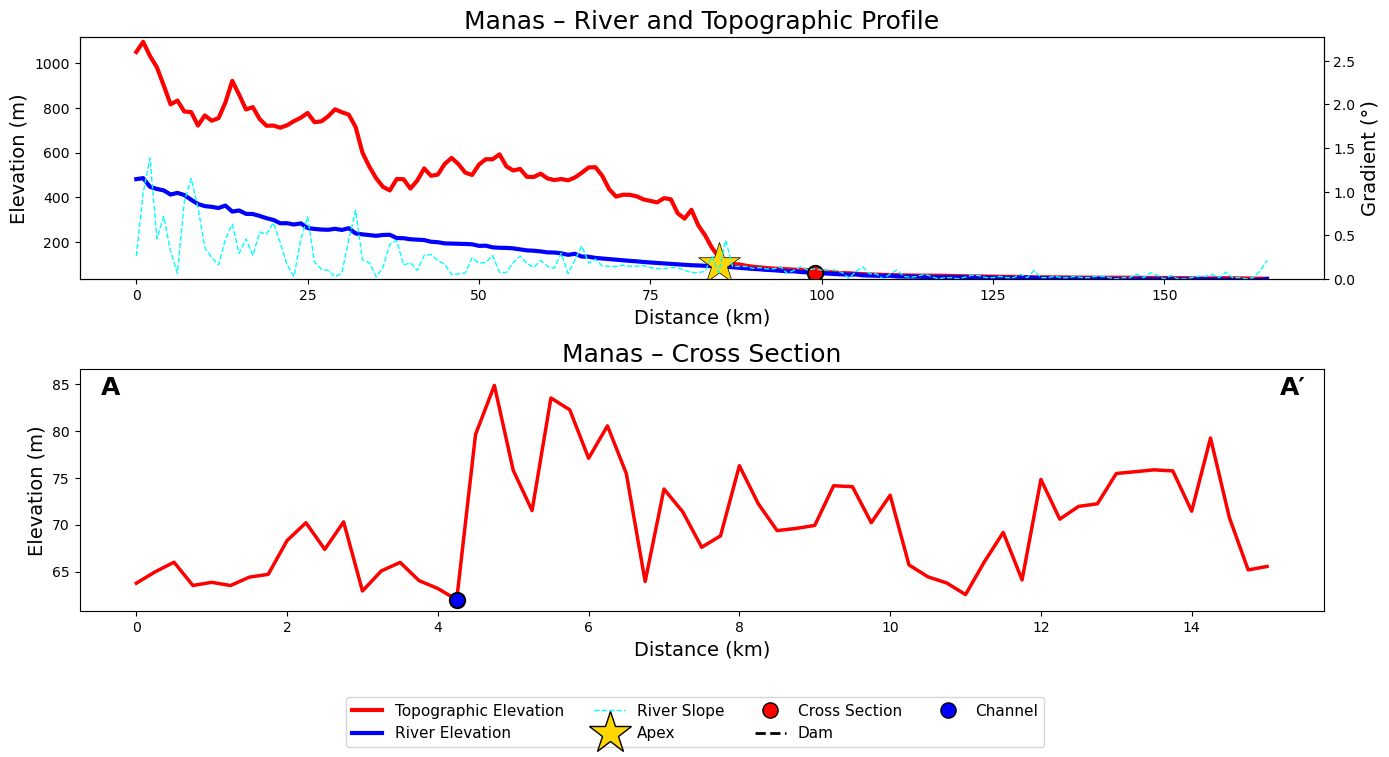

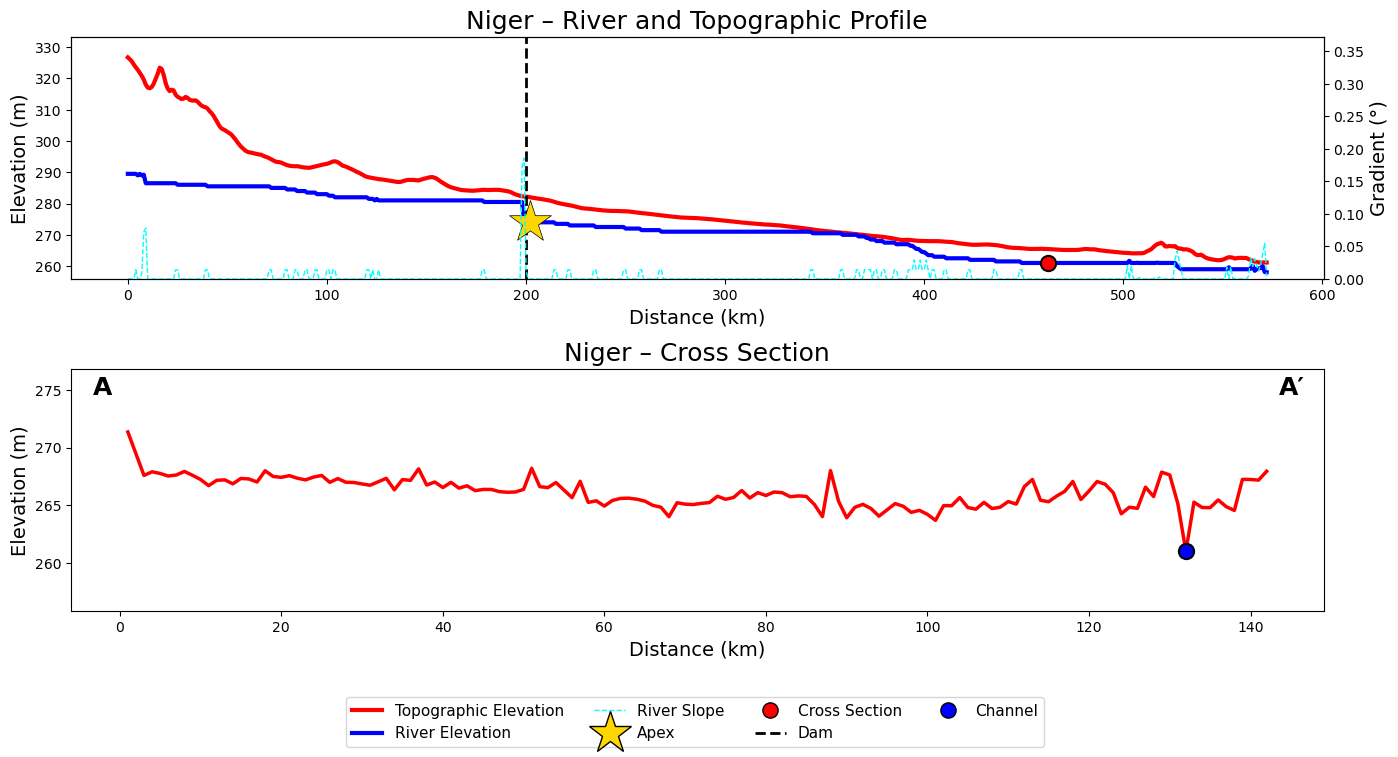

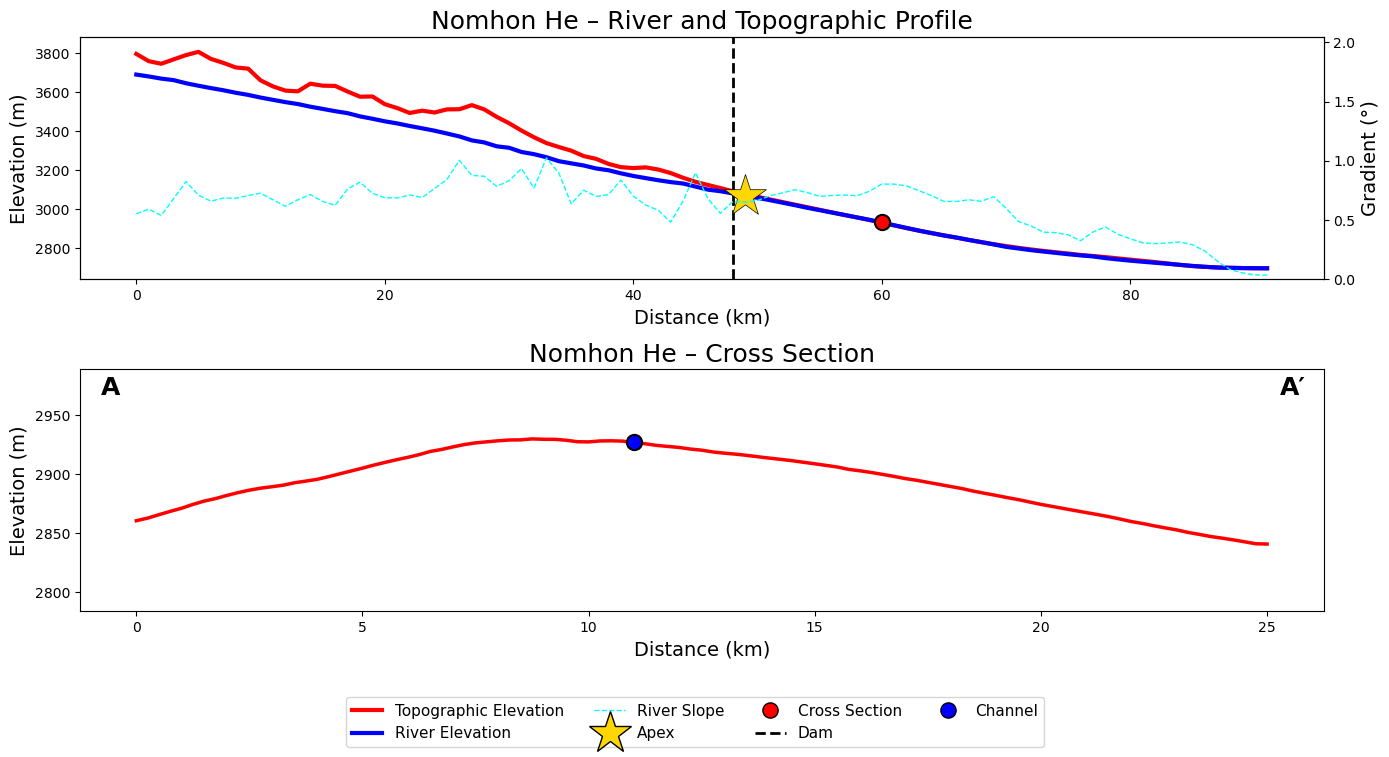

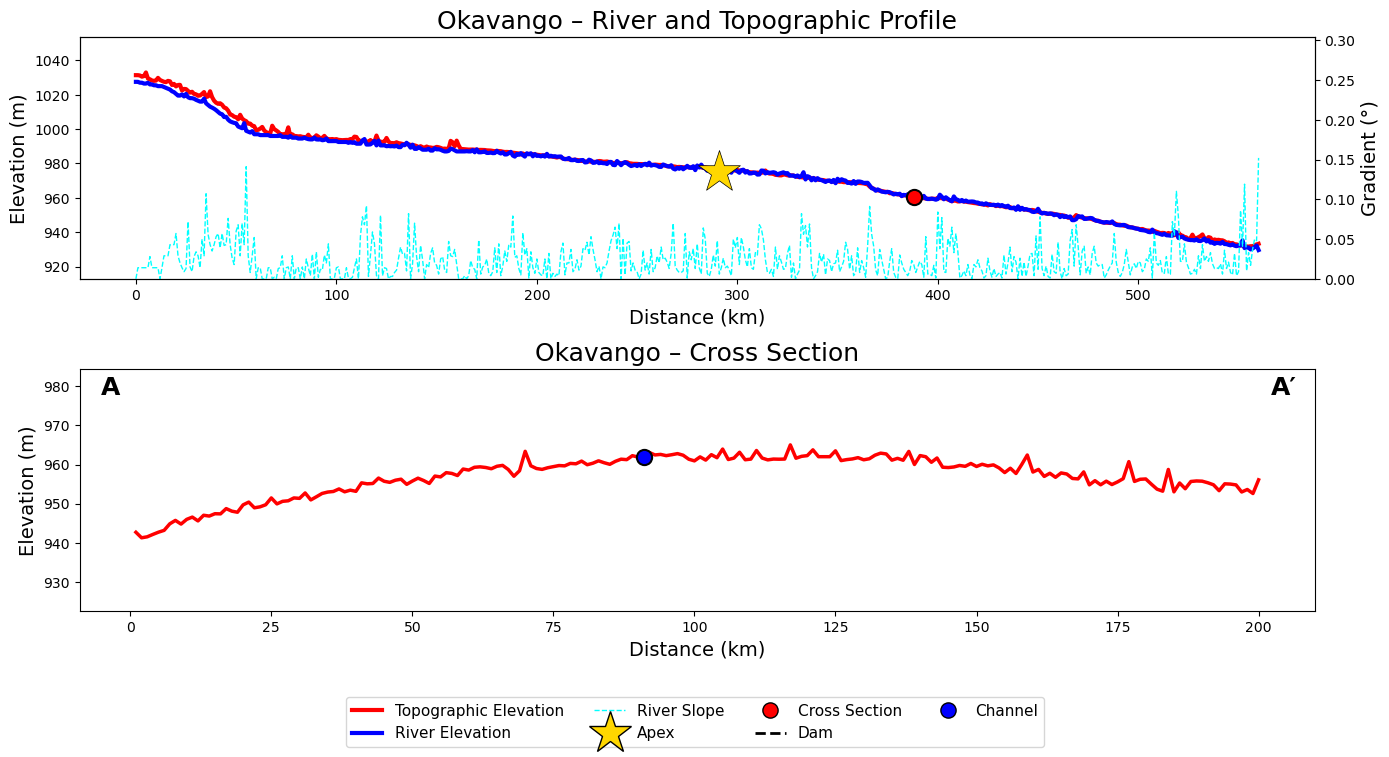

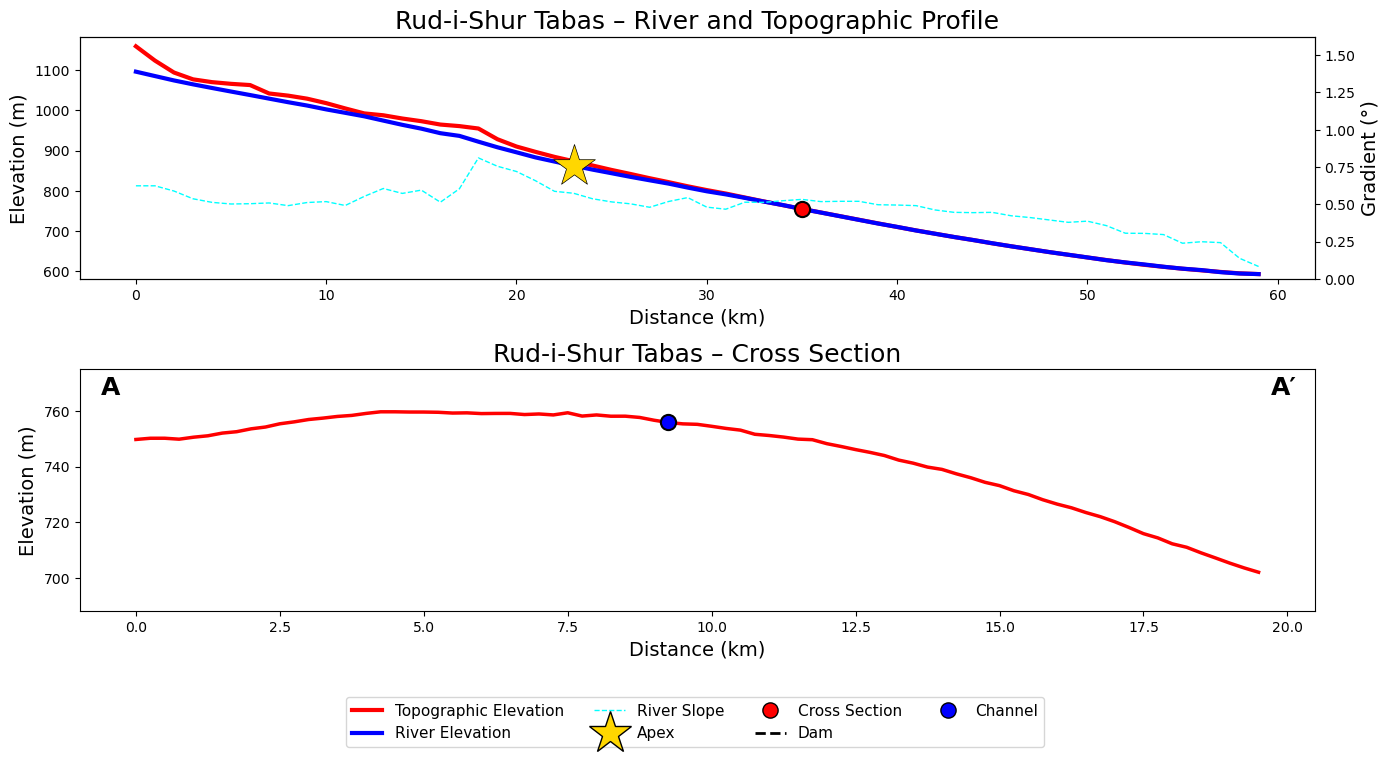

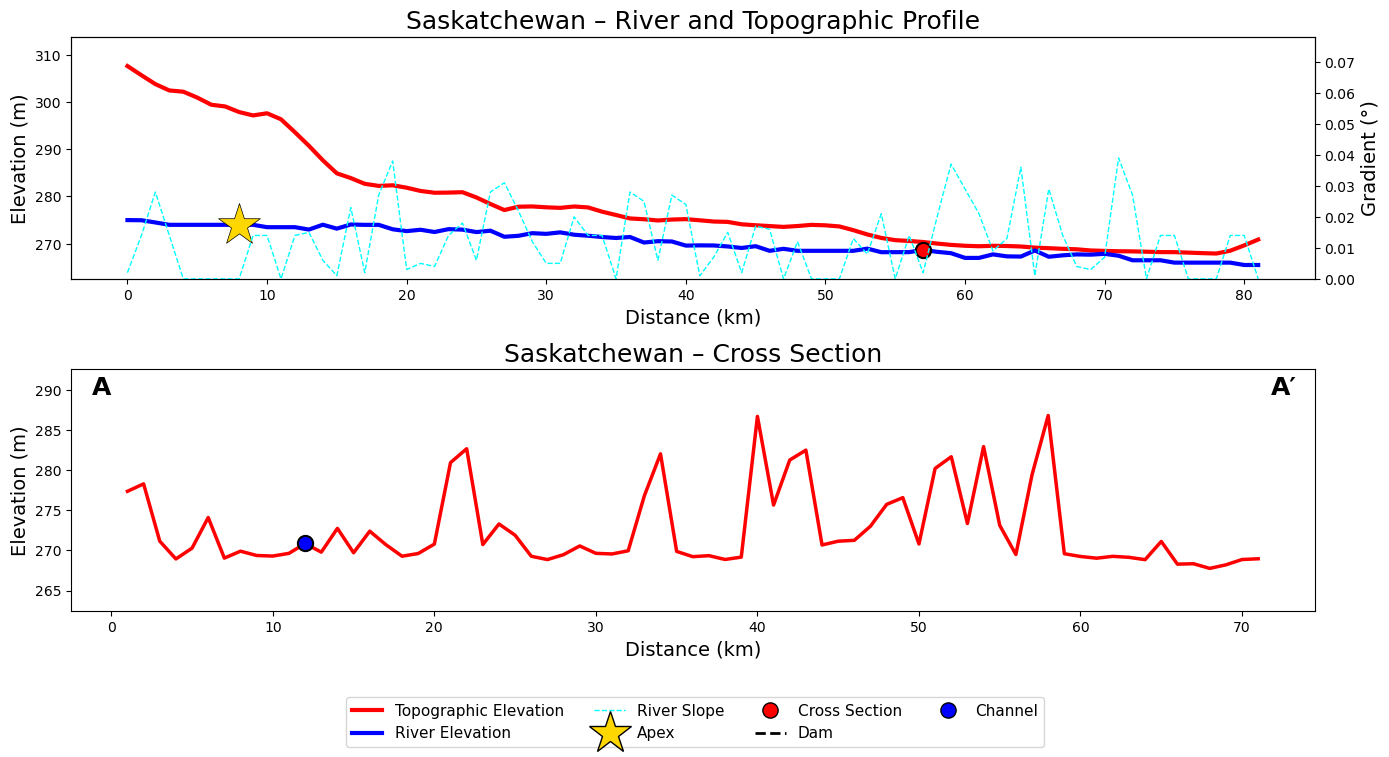

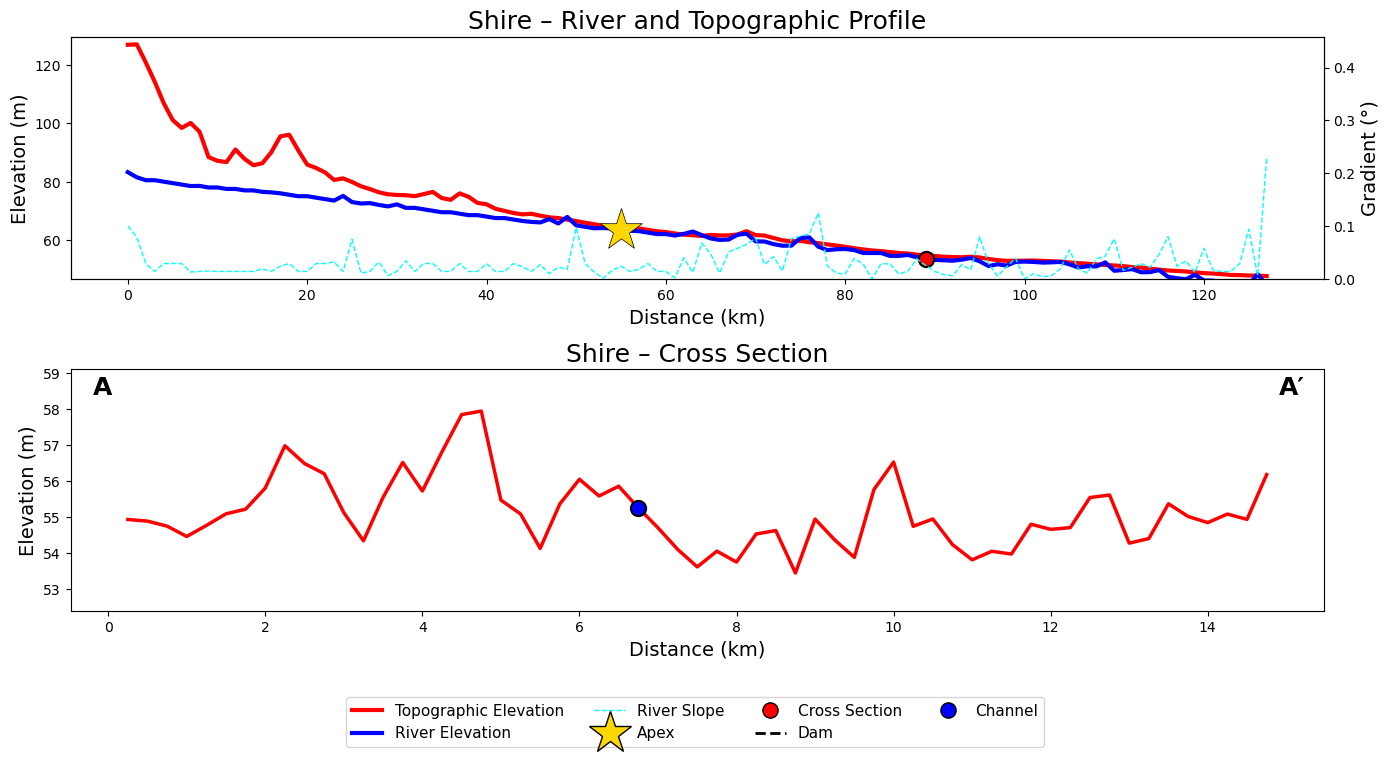

In [23]:
# =====================================================
# Plot each fan as a separate figure:
#   Top = River & Topographic Profile (scaled by df2 Mean Elevation)
#   Bottom = Cross Section (scaled by df3 Elevation)
# =====================================================

df2.columns = df2.columns.str.strip()
df3.columns = df3.columns.str.strip()

fan_list = sorted(set(df2['Fan']).intersection(df3['Fan']))

dam_dict = {'Nomhon He': [48], 'Niger': [200]}

# Style constants
window_topo = 1
window_river = 1
window_slope = 10
apex_marker_size = 1000
cross_marker_size = 120
channel_circle_size = 120
channel_edgewidth = 1.5
x_offset = 0.025
y_fixed = 0.975
label_size = 18

for fan_name in fan_list:
    # --- Prepare data ---
    df_fan2 = df2[df2['Fan'] == fan_name].copy().sort_values("Distance")
    df_fan3 = df3[df3['Fan'] == fan_name].copy().sort_values("Distance")

    # Interpolate missing values
    df_fan2['Mean Elevation'] = df_fan2['Mean Elevation'].interpolate(method='linear')
    df_fan2['River Elevation'] = df_fan2['River Elevation'].interpolate(method='linear')
    df_fan3['Elevation'] = df_fan3['Elevation'].interpolate(method='linear')

    # Smooth
    df_fan2['Topo_elev_smooth']  = df_fan2['Mean Elevation'].rolling(window=window_topo,  center=True).mean()
    df_fan2['River_elev_smooth'] = df_fan2['River Elevation'].rolling(window=window_river, center=True).mean()

    # Compute slope (in degrees)
    gradient_river = np.gradient(df_fan2['River Elevation'], df_fan2['Distance'] * 1000)
    df_fan2['River_slope_deg_smooth'] = np.degrees(np.arctan(np.abs(gradient_river))).round(3)

    # === Determine y-axis limits ===
    # Top plot → based on df2 Mean Elevation
    y_min_profile = 0.98 * df_fan2['Mean Elevation'].min()
    y_max_profile = 1.02 * df_fan2['Mean Elevation'].max()

    # Bottom plot → based on df3 Elevation
    y_min_cross = 0.98 * df_fan3['Elevation'].min()
    y_max_cross = 1.02 * df_fan3['Elevation'].max()

    # =====================================================
    # Create figure
    # =====================================================
    fig, (ax_profile, ax_cross) = plt.subplots(2, 1, figsize=(14, 8), sharex=False)
    fig.subplots_adjust(bottom=0.28)  # extra room for legend below x-axis

    # =====================================================
    # TOP: River & Topographic Profile (df2)
    # =====================================================
    ax_profile.plot(df_fan2['Distance'], df_fan2['Topo_elev_smooth'],
                    color='red', linewidth=3, zorder=1)
    ax_profile.plot(df_fan2['Distance'], df_fan2['River_elev_smooth'],
                    color='blue', linewidth=3, zorder=2)

    # Dams
    for dam in dam_dict.get(fan_name, []):
        ax_profile.axvline(x=dam, color='black', linestyle='--', linewidth=2, zorder=3)

    # Apex markers
    if 'Apex' in df_fan2.columns:
        apex_data = df_fan2[df_fan2['Apex'] == 'Apex']
        if not apex_data.empty:
            ax_profile.scatter(apex_data['Distance'],
                               df_fan2.loc[apex_data.index, 'River_elev_smooth'],
                               marker='*', s=apex_marker_size, color='gold',
                               edgecolor='black', linewidths=0.5, zorder=5)

    # Cross-section markers
    if 'Cross Section' in df_fan2.columns:
        cross_data = df_fan2[df_fan2['Cross Section'] == 'Cross Section']
        if not cross_data.empty:
            ax_profile.scatter(cross_data['Distance'],
                               df_fan2.loc[cross_data.index, 'River_elev_smooth'],
                               marker='o', s=cross_marker_size, color='red',
                               edgecolor='black', linewidths=1.5, zorder=6)

    # Y-axis scaling based on df2 mean elevation
    ax_profile.set_ylim(y_min_profile, y_max_profile)
    ax_profile.set_xlabel('Distance (km)', fontsize=14)
    ax_profile.set_ylabel('Elevation (m)', fontsize=14)
    ax_profile.set_title(f"{fan_name} – River and Topographic Profile", fontsize=18)
    ax_profile.tick_params(axis='both', labelsize=10)
    ax_profile.grid(False)

    # Secondary y-axis: slope
    ax2 = ax_profile.twinx()
    ax2.plot(df_fan2['Distance'], df_fan2['River_slope_deg_smooth'],
             color='cyan', linestyle='--', linewidth=1)
    ax2.set_ylabel('Gradient (°)', fontsize=14)
    ax2.tick_params(axis='y', labelsize=10)
    max_slope = df_fan2['River_slope_deg_smooth'].max()
    ax2.set_ylim(0, 2 * max_slope if max_slope > 0 else 0.5)

    # =====================================================
    # BOTTOM: Cross Section (df3)
    # =====================================================
    ax_cross.plot(df_fan3['Distance'], df_fan3['Elevation'],
                  color='red', linewidth=2.5, zorder=1)

    df_channel = df_fan3[df_fan3['Channel'] == "Channel"]
    if not df_channel.empty:
        ax_cross.scatter(df_channel['Distance'], df_channel['Elevation'],
                         color='blue', s=channel_circle_size,
                         edgecolor='black', linewidths=channel_edgewidth,
                         marker='o', zorder=2)

    # A / A′ labels
    ax_cross.text(x_offset, y_fixed, "A", fontsize=label_size, fontweight='bold',
                  ha='center', va='top', transform=ax_cross.transAxes)
    ax_cross.text(1 - x_offset, y_fixed, "A′", fontsize=label_size, fontweight='bold',
                  ha='center', va='top', transform=ax_cross.transAxes)

    # Y-axis scaling based on df3 elevation
    ax_cross.set_ylim(y_min_cross, y_max_cross)
    ax_cross.set_xlabel('Distance (km)', fontsize=14)
    ax_cross.set_ylabel('Elevation (m)', fontsize=14)
    ax_cross.set_title(f"{fan_name} – Cross Section", fontsize=18)
    ax_cross.tick_params(axis='both', labelsize=10)
    ax_cross.grid(False)

    # =====================================================
    # Legend (moved lower to avoid x-axis overlap)
    # =====================================================
    legend_handles = [
        Line2D([0], [0], color='red',  linewidth=3, label='Topographic Elevation'),
        Line2D([0], [0], color='blue', linewidth=3, label='River Elevation'),
        Line2D([0], [0], color='cyan', linestyle='--', linewidth=1, label='River Slope'),
        Line2D([0], [0], marker='*', color='gold', markerfacecolor='gold',
               markersize=np.sqrt(apex_marker_size), markeredgecolor='black',
               linestyle='None', label='Apex'),
        Line2D([0], [0], marker='o', color='red', markerfacecolor='red',
               markeredgecolor='black', markersize=np.sqrt(cross_marker_size),
               linestyle='None', label='Cross Section'),
        Line2D([0], [0], color='black', linestyle='--', linewidth=2, label='Dam'),
        Line2D([0], [0], marker='o', color='blue', markerfacecolor='blue',
               markeredgecolor='black', markersize=np.sqrt(channel_circle_size),
               linestyle='None', label='Channel')
    ]

    fig.legend(handles=legend_handles, loc='lower center', ncol=4, fontsize=11,
               bbox_to_anchor=(0.5, 0.02))  # moved lower down

    plt.tight_layout(rect=[0, 0.12, 1, 0.97])  # extra bottom space for legend
    plt.show()
